## Decision Trees for multiclassification

### Import Data

In [207]:
#! pip install xgboost
#! pip install imblearn
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score,roc_curve, roc_auc_score
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

### Read all the CSV files

In [32]:
%%time
df= pd.read_csv('CSV/flights_fact.csv',low_memory=False)

CPU times: total: 16.7 s
Wall time: 20.6 s


In [33]:
aircraft_dim= pd.read_csv('CSV/aircraft_dim.csv')
aircraft_dim = aircraft_dim.rename(columns={'N-Number': 'TAIL_NUMBER'})

In [34]:
date_dim=pd.read_csv('CSV/date_dim.csv')

In [35]:
arrivalAirport_dim=pd.read_csv('CSV/arrivalAirport_dim.csv')
arrivalAirport_dim = arrivalAirport_dim.rename(columns={'IATA_CODE': 'DESTINATION_AIRPORT'})

In [36]:
departureAirport_dim=pd.read_csv('CSV/departureAirport_dim.csv')
departureAirport_dim = departureAirport_dim.rename(columns={'IATA_CODE': 'ORIGIN_AIRPORT'})

In [37]:
departureTime_dim=pd.read_csv('CSV/departureTime_dim.csv')

In [38]:
arrivalTime_dim=pd.read_csv('CSV/arrivalTime_dim.csv')

* Merge the fact table with the dimension tables

In [39]:
%%time

df=pd.merge(df,aircraft_dim, on='TAIL_NUMBER', how='inner')
df=pd.merge(df,date_dim, on='dateKey', how='inner')
df=pd.merge(df,arrivalAirport_dim, on='DESTINATION_AIRPORT', how='inner')
df=pd.merge(df,departureAirport_dim, on='ORIGIN_AIRPORT', how='inner')
df=pd.merge(df,departureTime_dim,on='scheduledDeparture_key',how='inner')
df=pd.merge(df,arrivalTime_dim,on='scheduledArrival_key',how='inner')

CPU times: total: 22.6 s
Wall time: 25 s


* Create a new method called get_value that creates a new column called 'class' and assigns the values 0,1,2 to the classes early,on_time,delayed respectively if those classes appear to be 1 in the initial dataset.

In [14]:
%%time 

def get_value(df):
    if df['early'] == 1:
        return 0
    elif df['on_time'] == 1:
        return 1
    elif df['delayed'] == 1:
        return 2

df['class'] = df.apply(lambda df: get_value(df), axis=1)


CPU times: total: 56.2 s
Wall time: 1min 29s


In [218]:
df['delayed'].value_counts()

0    3318731
1     592537
Name: delayed, dtype: int64

In [219]:
df

,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_TIME,DISTANCE,dateKey,delayed,LATITUDE_x,LONGITUDE_x,LATITUDE_y,LONGITUDE_y,...,EV,F9,HA,MQ,NK,OO,UA,US,VX,WN
0,2354.0,-11.0,205.0,1448,20150101,0,47.44898,-122.30931,61.17432,-149.99619,...,0,0,0,0,0,0,0,0,0,0
1,2353.0,-12.0,205.0,1448,20150102,0,47.44898,-122.30931,61.17432,-149.99619,...,0,0,0,0,0,0,0,0,0,0
2,41.0,36.0,205.0,1448,20150104,1,47.44898,-122.30931,61.17432,-149.99619,...,0,0,0,0,0,0,0,0,0,0
3,2358.0,-7.0,205.0,1448,20150108,0,47.44898,-122.30931,61.17432,-149.99619,...,0,0,0,0,0,0,0,0,0,0
4,2354.0,-11.0,205.0,1448,20150109,0,47.44898,-122.30931,61.17432,-149.99619,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3919448,10.0,-4.0,161.0,1012,20151129,0,27.97547,-82.53325,41.97960,-87.90446,...,0,0,0,0,0,0,1,0,0,0
3919449,10.0,-4.0,161.0,1012,20151130,0,27.97547,-82.53325,41.97960,-87.90446,...,0,0,0,0,0,0,1,0,0,0
3919450,16.0,2.0,186.0,1024,20151219,0,47.44898,-122.30931,39.85841,-104.66700,...,0,0,0,0,0,0,1,0,0,0
3919451,48.0,26.0,130.0,773,20151228,1,32.12758,-81.20214,41.97960,-87.90446,...,1,0,0,0,0,0,0,0,0,0


### Print merged Dataframe 

In [40]:
df.columns

Index(['AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT',
       'DESTINATION_AIRPORT', 'scheduledDeparture_key', 'DEPARTURE_TIME',
       'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME',
       'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN',
       'scheduledArrival_key', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'DIVERTED',
       'CANCELLED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY',
       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
       'WEATHER_DELAY', 'dateKey', 'early', 'on_time', 'delayed', 'new_delay',
       'AircraftMFRModelCode', 'Year Mfr', 'TypeAcft', 'mfr_name',
       'model_name', 'type', 'num_engines', 'num_passengers', 'YEAR', 'MONTH',
       'DAY', 'DAY_OF_WEEK', 'fullDate', 'month_name', 'day_name', 'AIRPORT_x',
       'CITY_x', 'STATE_x', 'COUNTRY_x', 'LATITUDE_x', 'LONGITUDE_x',
       'AIRPORT_y', 'CITY_y', 'STATE_y', 'COUNTRY_y', 'LATITUDE_y',
       'LONGITUDE_y', 'Hour_x', 'Minute_x', 'Hour_y', 'Minute_y'],
   

### Remove unwanted columns

In [41]:
df=df.drop(['YEAR','FLIGHT_NUMBER','TAIL_NUMBER','TAXI_OUT','WHEELS_OFF','ELAPSED_TIME', 'AIR_TIME','WHEELS_ON',
            'TAXI_IN','CANCELLATION_REASON','ARRIVAL_DELAY','early','on_time',
              'new_delay','DIVERTED','CANCELLED','AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY',
                    'WEATHER_DELAY','YEAR','LATE_AIRCRAFT_DELAY','num_engines','num_passengers','Year Mfr','TypeAcft',
           'type','AircraftMFRModelCode','COUNTRY_x','COUNTRY_y','mfr_name','scheduledArrival_key','scheduledDeparture_key',
           'DAY', 'DAY_OF_WEEK', 'fullDate', 'month_name', 'day_name','CITY_x', 'STATE_x',
            'COUNTRY_x','CITY_y', 'STATE_y', 'COUNTRY_y','model_name'], axis=1)


In [42]:
df.isna().sum()

AIRLINE                   0
ORIGIN_AIRPORT            0
DESTINATION_AIRPORT       0
DEPARTURE_TIME            0
DEPARTURE_DELAY           0
SCHEDULED_TIME            0
DISTANCE                  0
ARRIVAL_TIME              0
dateKey                   0
delayed                   0
MONTH                     0
AIRPORT_x                 0
LATITUDE_x             4132
LONGITUDE_x            4132
AIRPORT_y                 0
LATITUDE_y             4053
LONGITUDE_y            4053
Hour_x                    0
Minute_x                  0
Hour_y                    0
Minute_y                  0
dtype: int64

In [43]:
df.dropna(subset=['LATITUDE_x','LATITUDE_y','LONGITUDE_x','LONGITUDE_y'], inplace=True)

In [44]:
df.isna().sum()

AIRLINE                0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
DEPARTURE_TIME         0
DEPARTURE_DELAY        0
SCHEDULED_TIME         0
DISTANCE               0
ARRIVAL_TIME           0
dateKey                0
delayed                0
MONTH                  0
AIRPORT_x              0
LATITUDE_x             0
LONGITUDE_x            0
AIRPORT_y              0
LATITUDE_y             0
LONGITUDE_y            0
Hour_x                 0
Minute_x               0
Hour_y                 0
Minute_y               0
dtype: int64

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3911268 entries, 0 to 3919452
Data columns (total 35 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   AIRLINE                 object 
 1   ORIGIN_AIRPORT          object 
 2   DESTINATION_AIRPORT     object 
 3   scheduledDeparture_key  int64  
 4   DEPARTURE_TIME          float64
 5   DEPARTURE_DELAY         float64
 6   SCHEDULED_TIME          float64
 7   DISTANCE                int64  
 8   scheduledArrival_key    int64  
 9   ARRIVAL_TIME            float64
 10  dateKey                 int64  
 11  Unnamed: 0              int64  
 12  mfr_name                object 
 13  model_name              object 
 14  MONTH                   int64  
 15  DAY                     int64  
 16  DAY_OF_WEEK             int64  
 17  fullDate                object 
 18  month_name              object 
 19  day_name                object 
 20  AIRPORT_x               object 
 21  CITY_x                  object 

### Perform Correlation Statistic Test

<AxesSubplot: >

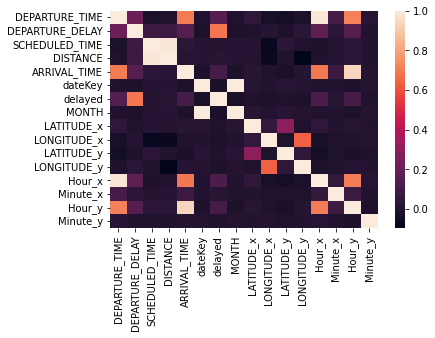

In [45]:
sns.heatmap(df.corr())

In [47]:
#columns=['FLIGHT_NUMBER','TAIL_NUMBER','scheduledDeparture_key','DEPARTURE_DELAY','TAXI_OUT','WHEELS_OFF',
               #'AIR_TIME','WHEELS_ON','TAXI_IN','scheduledArrival_key','ARRIVAL_DELAY','early','on_time','delayed',
              #'new_delay','class'])
# Select the target variable
y = df['delayed']

# Select the feature columns
X = df.drop(columns=['delayed'])

# Compute the correlation matrix
corr = X.corrwith(y)

# Sort the correlations in descending order
corr_sorted = corr.sort_values(ascending=False)

# Print the sorted correlations
corr_sorted



DEPARTURE_DELAY    0.684964
DEPARTURE_TIME     0.143077
Hour_x             0.121525
Hour_y             0.103325
ARRIVAL_TIME       0.100323
Minute_x           0.017736
DISTANCE           0.016991
SCHEDULED_TIME     0.009460
Minute_y           0.000336
LATITUDE_y        -0.006811
LATITUDE_x        -0.007174
LONGITUDE_x       -0.013182
LONGITUDE_y       -0.015154
MONTH             -0.023621
dateKey           -0.023746
dtype: float64

In [48]:
df

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_TIME,DISTANCE,ARRIVAL_TIME,dateKey,delayed,...,AIRPORT_x,LATITUDE_x,LONGITUDE_x,AIRPORT_y,LATITUDE_y,LONGITUDE_y,Hour_x,Minute_x,Hour_y,Minute_y
0,AS,ANC,SEA,2354.0,-11.0,205.0,1448,408.0,20150101,0,...,Seattle-Tacoma International Airport,47.44898,-122.30931,Ted Stevens Anchorage International Airport,61.17432,-149.99619,0,5,4,30
1,AS,ANC,SEA,2353.0,-12.0,205.0,1448,403.0,20150102,0,...,Seattle-Tacoma International Airport,47.44898,-122.30931,Ted Stevens Anchorage International Airport,61.17432,-149.99619,0,5,4,30
2,AS,ANC,SEA,41.0,36.0,205.0,1448,449.0,20150104,1,...,Seattle-Tacoma International Airport,47.44898,-122.30931,Ted Stevens Anchorage International Airport,61.17432,-149.99619,0,5,4,30
3,AS,ANC,SEA,2358.0,-7.0,205.0,1448,405.0,20150108,0,...,Seattle-Tacoma International Airport,47.44898,-122.30931,Ted Stevens Anchorage International Airport,61.17432,-149.99619,0,5,4,30
4,AS,ANC,SEA,2354.0,-11.0,205.0,1448,417.0,20150109,0,...,Seattle-Tacoma International Airport,47.44898,-122.30931,Ted Stevens Anchorage International Airport,61.17432,-149.99619,0,5,4,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3919448,UA,ORD,TPA,10.0,-4.0,161.0,1012,346.0,20151129,0,...,Tampa International Airport,27.97547,-82.53325,Chicago O'Hare International Airport,41.97960,-87.90446,0,14,3,55
3919449,UA,ORD,TPA,10.0,-4.0,161.0,1012,343.0,20151130,0,...,Tampa International Airport,27.97547,-82.53325,Chicago O'Hare International Airport,41.97960,-87.90446,0,14,3,55
3919450,UA,DEN,SEA,16.0,2.0,186.0,1024,209.0,20151219,0,...,Seattle-Tacoma International Airport,47.44898,-122.30931,Denver International Airport,39.85841,-104.66700,0,14,2,20
3919451,EV,ORD,SAV,48.0,26.0,130.0,773,349.0,20151228,1,...,Savannah/Hilton Head International Airport,32.12758,-81.20214,Chicago O'Hare International Airport,41.97960,-87.90446,0,22,3,32


In [49]:

# Multiply the values in the "hour" column by 60]
df["hour_minutes_dep"] = df["Hour_x"] * 60

# Add the resulting values to the values in the "minute" column
df["total_minutes_dep"] = df["hour_minutes_dep"] + df["Minute_x"]

# Drop the original "hour" and "minute" columns
df = df.drop(columns=["Hour_x", "Minute_x"])

In [50]:

# Multiply the values in the "hour" column by 60]
df["hour_minutes_arr"] = df["Hour_y"] * 60

# Add the resulting values to the values in the "minute" column
df["total_minutes_arr"] = df["hour_minutes_arr"] + df["Minute_y"]

# Drop the original "hour" and "minute" columns
df = df.drop(columns=["Hour_y", "Minute_y"])

In [217]:
df["total_minutes_arr"].describe()

count    3.911268e+06
mean     8.978087e+02
std      3.034065e+02
min      1.000000e+00
25%      6.600000e+02
50%      9.030000e+02
75%      1.145000e+03
max      1.439000e+03
Name: total_minutes_arr, dtype: float64

* Use the OneHotEncoder class from the sklearn.preprocessing module to perform one-hot encoding on the categorical column.

In [54]:
%%time
dummies = pd.get_dummies(df['AIRLINE'])
dummies

CPU times: total: 391 ms
Wall time: 425 ms


,AA,AS,B6,DL,EV,F9,HA,MQ,NK,OO,UA,US,VX,WN
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3919448,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3919449,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3919450,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3919451,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [55]:
df=pd.concat([df, dummies], axis=1)
df = df.drop(['AIRLINE', 'ORIGIN_AIRPORT','DESTINATION_AIRPORT'], axis=1)

In [56]:
df.columns

Index(['DEPARTURE_TIME', 'DEPARTURE_DELAY', 'SCHEDULED_TIME', 'DISTANCE',
       'ARRIVAL_TIME', 'dateKey', 'delayed', 'MONTH', 'AIRPORT_x',
       'LATITUDE_x', 'LONGITUDE_x', 'AIRPORT_y', 'LATITUDE_y', 'LONGITUDE_y',
       'total_minutes_dep', 'total_minutes_arr', 'AA', 'AS', 'B6', 'DL', 'EV',
       'F9', 'HA', 'MQ', 'NK', 'OO', 'UA', 'US', 'VX', 'WN'],
      dtype='object')

In [57]:
#columns=['FLIGHT_NUMBER','TAIL_NUMBER','scheduledDeparture_key','DEPARTURE_DELAY','TAXI_OUT','WHEELS_OFF',
               #'AIR_TIME','WHEELS_ON','TAXI_IN','scheduledArrival_key','ARRIVAL_DELAY','early','on_time','delayed',
              #'new_delay','class'])
# Select the target variable
y = df['delayed']

# Select the feature columns
X = df.drop(columns=['delayed'])

# Compute the correlation matrix
corr = X.corrwith(y)

# Sort the correlations in descending order
corr_sorted = corr.sort_values(ascending=False,key=abs)

# Print the sorted correlations
corr_sorted.head(20)


DEPARTURE_DELAY      0.684964
DEPARTURE_TIME       0.143077
total_minutes_dep    0.121991
total_minutes_arr    0.103264
ARRIVAL_TIME         0.100323
DL                  -0.058200
WN                   0.040239
NK                   0.031276
dateKey             -0.023746
MONTH               -0.023621
F9                   0.021468
DISTANCE             0.016991
LONGITUDE_y         -0.015154
LONGITUDE_x         -0.013182
B6                   0.010427
AA                  -0.009526
SCHEDULED_TIME       0.009460
OO                  -0.007326
LATITUDE_x          -0.007174
LATITUDE_y          -0.006811
dtype: float64

* Info and analysis of data

In [58]:
df.isnull().any().value_counts()

False    30
dtype: int64

In [59]:
df.columns

Index(['DEPARTURE_TIME', 'DEPARTURE_DELAY', 'SCHEDULED_TIME', 'DISTANCE',
       'ARRIVAL_TIME', 'dateKey', 'delayed', 'MONTH', 'AIRPORT_x',
       'LATITUDE_x', 'LONGITUDE_x', 'AIRPORT_y', 'LATITUDE_y', 'LONGITUDE_y',
       'total_minutes_dep', 'total_minutes_arr', 'AA', 'AS', 'B6', 'DL', 'EV',
       'F9', 'HA', 'MQ', 'NK', 'OO', 'UA', 'US', 'VX', 'WN'],
      dtype='object')

In [60]:
df=df.drop(['MONTH','ARRIVAL_TIME','AIRPORT_y','AIRPORT_x'],axis=1)

In [61]:
df.columns

Index(['DEPARTURE_TIME', 'DEPARTURE_DELAY', 'SCHEDULED_TIME', 'DISTANCE',
       'dateKey', 'delayed', 'LATITUDE_x', 'LONGITUDE_x', 'LATITUDE_y',
       'LONGITUDE_y', 'total_minutes_dep', 'total_minutes_arr', 'AA', 'AS',
       'B6', 'DL', 'EV', 'F9', 'HA', 'MQ', 'NK', 'OO', 'UA', 'US', 'VX', 'WN'],
      dtype='object')

### Decision Trees

* Assign to x all the features that we will use for prediction and assign to y the class feature that we want to predict

In [155]:
x= df.drop(['delayed','DEPARTURE_TIME', 'DEPARTURE_DELAY','LATITUDE_x','LATITUDE_y','AA','OO','SCHEDULED_TIME','B6','AS', 'EV' ,'HA',
       'MQ','UA', 'US', 'VX'],axis=1)  
y= df['delayed']

In [156]:
x.columns

Index(['DISTANCE', 'dateKey', 'LONGITUDE_x', 'LONGITUDE_y',
       'total_minutes_dep', 'total_minutes_arr', 'DL', 'F9', 'NK', 'WN'],
      dtype='object')

* Split to trainning and testing set with a 80:20 ratio

In [157]:
x_train, x_test, y_train, y_test= train_test_split(x, y, test_size= 0.25,random_state=0)  

In [158]:
# define the SMOTE model
smote = SMOTE()
# fit and transform the training data
X_train_resampled_tree, y_train_resampled_tree = smote.fit_resample(x_train, y_train)

In [162]:
y_train_resampled_tree.value_counts()

0    2489534
1    2489534
Name: delayed, dtype: int64

* Create a DecisionTreeClassifier based on the entropy

In [159]:
%%time
#Entropy
classifier= DecisionTreeClassifier(criterion='entropy', random_state=0)  
model=classifier.fit(X_train_resampled_tree, y_train_resampled_tree)  

CPU times: total: 2min 39s
Wall time: 2min 47s


* Predicting the test set result based on the Entropy

In [160]:
#Predicting the test set result (Entropy)
y_pred= classifier.predict(x_test)

In [161]:
print(classifier.tree_.max_depth)

71


 Create a DecisionTreeClassifier based on the gini index

In [100]:
%%time
#Gini
classifier1= DecisionTreeClassifier(criterion='gini', random_state=0)  
model1=classifier1.fit(x_train, y_train) 

CPU times: total: 38.2 s
Wall time: 40.4 s


* Predicting the test set result based on the gini index

In [101]:
#Predicting the test set result (Gini)
y_pred1= classifier1.predict(x_test)

In [103]:
print(classifier1.tree_.max_depth)

59


### Print the classification report and interpret the results

In [163]:
# Print the classification report (Entropy)
report = classification_report(y_test, y_pred)
print(report)

# Print the F1 score
f1 = f1_score(y_test, y_pred, average="micro")
print("F1 score:", f1)

              precision    recall  f1-score   support

           0       0.87      0.82      0.85    829197
           1       0.25      0.33      0.29    148620

    accuracy                           0.75    977817
   macro avg       0.56      0.58      0.57    977817
weighted avg       0.78      0.75      0.76    977817

F1 score: 0.745739744757966


In [104]:
# Print the classification report(Gini)
report = classification_report(y_test, y_pred1)
print(report)

# Print the F1 score
f1 = f1_score(y_test, y_pred1, average="micro")
print("F1 score:", f1)

              precision    recall  f1-score   support

           0       0.86      0.89      0.88    829197
           1       0.26      0.22      0.24    148620

    accuracy                           0.79    977817
   macro avg       0.56      0.56      0.56    977817
weighted avg       0.77      0.79      0.78    977817

F1 score: 0.7871984226087294


### XGBOOST

In [123]:
# Remove duplicate columns
ex_df = df.loc[:, ~df.columns.duplicated()]

In [124]:
ex_df = ex_df.sample(frac=0.7, random_state=0)

In [125]:
x= ex_df.drop(['delayed','DEPARTURE_TIME', 'DEPARTURE_DELAY','LATITUDE_x','LATITUDE_y','AA','OO','SCHEDULED_TIME','B6','AS', 'EV' ,'HA',
       'MQ','UA', 'US', 'VX'],axis=1)  
y= ex_df['delayed']

In [126]:
x

,DISTANCE,dateKey,LONGITUDE_x,LONGITUDE_y,total_minutes_dep,total_minutes_arr,DL,F9,NK,WN
551728,134,20150525,-97.82780,-97.03720,530,584,0,0,0,0
2506701,302,20150501,-95.27889,-90.25803,1290,1360,0,0,0,1
2835629,370,20150817,-112.00806,-118.40807,980,1060,0,0,0,1
360939,927,20150620,-82.53325,-81.84940,370,515,0,1,0,0
3307267,399,20150924,-77.03772,-71.00518,1200,1294,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2794436,337,20150222,-118.40807,-122.22072,1040,1115,0,0,0,1
3309420,563,20150427,-106.37781,-104.66700,1180,1288,0,0,0,0
1728525,2139,20150905,-84.42694,-122.37484,1375,389,1,0,0,0
3070832,226,20150221,-84.42694,-80.94313,958,1032,0,0,0,0


In [117]:
x_train, x_test, y_train, y_test= train_test_split(x, y, test_size= 0.25,random_state=0)  

In [139]:
y_train.value_counts()

0    1742023
1     311393
Name: delayed, dtype: int64

### Use the SMOTE algorithm to oversample the minority class in the training set.

In [128]:
# define the SMOTE model
smote = SMOTE()
# fit and transform the training data
X_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

In [142]:
X_train_resampled

,DISTANCE,dateKey,LONGITUDE_x,LONGITUDE_y,total_minutes_dep,total_minutes_arr,DL,F9,NK,WN
0,337,20150119,-118.408070,-122.374840,995,1083,0,0,0,0
1,370,20150927,-112.008060,-118.408070,780,860,0,0,0,1
2,391,20150521,-111.977770,-104.667000,975,1060,0,0,0,1
3,353,20150310,-118.151610,-122.220720,550,625,0,0,0,0
4,2297,20150803,-115.152330,-72.683230,435,585,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
3484041,398,20150817,-108.429787,-107.613185,1036,1127,0,0,0,0
3484042,719,20150409,-88.664494,-75.022362,586,679,0,0,0,0
3484043,604,20150904,-90.001155,-86.001136,1319,1381,0,0,0,0
3484044,599,20150401,-81.720955,-80.943130,1330,1435,0,0,0,0


In [132]:
%%time
# Create the classifier
clf = XGBClassifier(max_depth=25,n_estimators=100)

# Fit the classifier to the training data
clf.fit(X_train_resampled, y_train_resampled)




CPU times: total: 2h 37min 47s
Wall time: 20min 41s


In [150]:
# Make predictions on the test data
predictions = clf.predict(x_test)

In [151]:
# Print the classification report(Gini)
report = classification_report(y_test, predictions)
print(report)

# Print the F1 score
f1 = f1_score(y_test, predictions, average="micro")
print("F1 score:", f1)

              precision    recall  f1-score   support

           0       0.94      0.93      0.93    829197
           1       0.62      0.65      0.64    148620

    accuracy                           0.89    977817
   macro avg       0.78      0.79      0.79    977817
weighted avg       0.89      0.89      0.89    977817

F1 score: 0.8873633819007033


In [178]:
predictions

0         0
1         0
2         1
3         0
4         0
         ..
977812    0
977813    0
977814    0
977815    0
977816    0
Length: 977817, dtype: int32

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

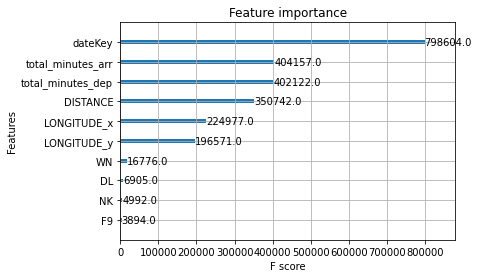

In [144]:
# Plot the feature importance scores, excluding the first two columns
xgb.plot_importance(clf,importance_type='weight', max_num_features=11)

### Evaluate the model 

In [164]:
# Evaluate the model on the test data
test_score = clf.score(x_test, y_test)

# Evaluate the model on the training data
train_score = clf.score(X_train_resampled, y_train_resampled)

# Print the scores
print(f"Test score: {test_score:.3f}")
print(f"Train score: {train_score:.3f}")

Test score: 0.887
Train score: 0.945


In [170]:
predictions = pd.Series(predictions)

In [175]:
y_test

551728     0
2506701    0
2835629    1
360939     0
3307267    0
          ..
735871     0
1561239    0
3645401    1
2744580    0
3082345    0
Name: delayed, Length: 977817, dtype: int64

In [187]:
confusion_matrix1

array([[770997,  58200],
       [ 51938,  96682]], dtype=int64)

<AxesSubplot: >

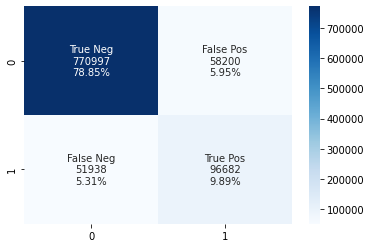

In [195]:
import seaborn as sns
import numpy as np
# compute the confusion matrix
confusion_matrix1 = confusion_matrix(y_test, predictions)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix1.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     confusion_matrix1.flatten()/np.sum(confusion_matrix1)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_matrix1, annot=labels, fmt='', cmap='Blues')

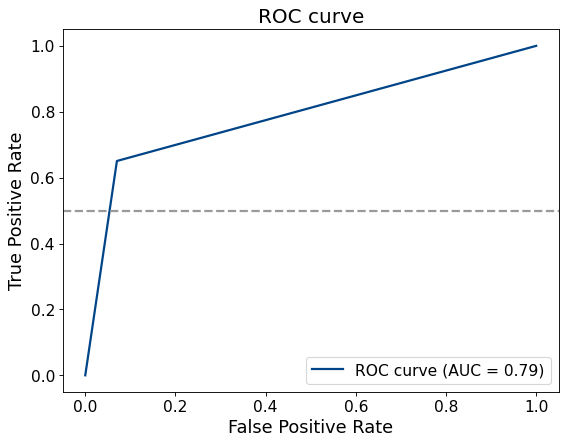

In [206]:
# Compute the false positive rate and true positive rate at different classification thresholds
fpr, tpr, thresholds = roc_curve(y_test,predictions)

# Compute the area under the curve (AUC)
auc = roc_auc_score(y_test, predictions)

# Create a figure and axis object with a specific size and aspect ratio
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)

# Plot the ROC curve
sns.lineplot(x=fpr, y=tpr, ax=ax, label='ROC curve (AUC = %0.2f)' % auc, color='#004488', lw=2)

# Add a title and axis labels
plt.title('ROC curve', fontsize=18)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)

# Customize the tick marks and tick labels on the x-axis and y-axis
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a horizontal line to show the random guess baseline
plt.axhline(y=0.5, linestyle='--', color='#999999', lw=2)

# Add a legend
plt.legend(fontsize=14, loc='lower right')

# Show the plot
plt.show()

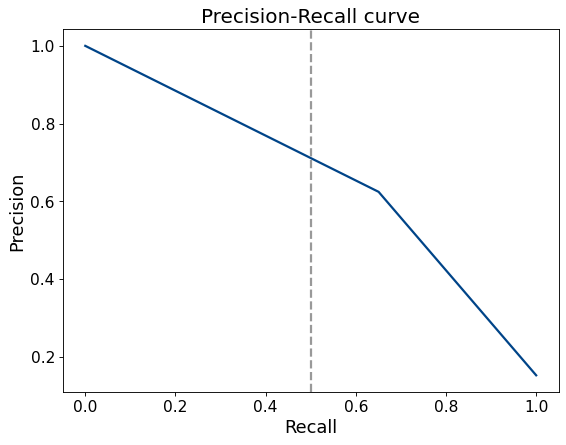

In [208]:

# Compute the precision and recall at different classification thresholds
precision, recall, thresholds = precision_recall_curve(y_test, predictions)

# Create a figure and axis object with a specific size and aspect ratio
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)

# Plot the precision-recall curve
sns.lineplot(x=recall, y=precision, ax=ax, color='#004488', lw=2)

# Add a title and axis labels
plt.title('Precision-Recall curve', fontsize=18)
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)

# Customize the tick marks and tick labels on the x-axis and y-axis
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a vertical line to show the random guess baseline
plt.axvline(x=0.5, linestyle='--', color='#999999', lw=2)

# Show the plot
plt.show()